<a href="https://colab.research.google.com/github/lim-jr/ESAA/blob/main/0320%EC%9B%94%EA%B3%BC%EC%A0%9C_%EC%BA%90%EA%B8%80%ED%95%84%EC%82%AC_stacked_reg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 라이브러리 및 데이터 로드


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
color = sns.color_palette()
sns.set_style("darkgrid")

import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn # ignore annoying warning

from scipy import stats
from scipy.stats import norm, skew # for some statistics

pd.options.display.float_format = '{:.3f}'.format # 지수표현 없애기
pd.set_option("display.float_format", lambda x: "{:.3f}".format(x)) # Limiting floats output to 3 decimal points

In [4]:
train = pd.read_csv("/content/drive/MyDrive/ESAA/데이터셋/st_train.csv")
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.000,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.000,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.000,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.000,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.000,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
test = pd.read_csv("/content/drive/MyDrive/ESAA/데이터셋/st_test.csv")
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.000,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.000,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.000,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.000,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.000,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [6]:
# check the numbers of samples and features
print("The train data size before dropping ID feature is : {}".format(train.shape))
print("The test data size before dropping ID feature is : {}".format(test.shape))

train_ID = train['Id']
test_ID = test['Id']

The train data size before dropping ID feature is : (1460, 81)
The test data size before dropping ID feature is : (1459, 80)


In [7]:
train.drop("Id", axis=1, inplace=True)
test.drop("Id", axis=1, inplace=True)

# check again the data size after dropping the "Id" variable
print("The train data size after dropping ID feature is : {}".format(train.shape))
print("The test data size after dropping ID feature is : {}".format(test.shape))

The train data size after dropping ID feature is : (1460, 80)
The test data size after dropping ID feature is : (1459, 79)


### 2. 데이터 전처리
### 2-1. Outliers
- x축을 GrLivArea, y축을 SalePrice로 하는 산점도를 그린다. 오른쪽 아래에 GrLivArea는 크지만 SalePrice는 작은 2개의 점이 보인다. 
- 이 2개의 점은 이상치로 판단되므로 두 점을 제거한다.

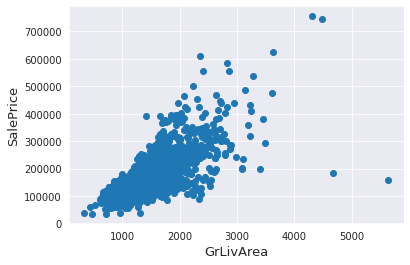

In [8]:
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()

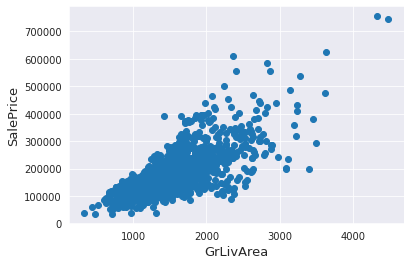

In [9]:
train = train.drop( train[ (train['GrLivArea']>4000)&(train['SalePrice']<300000) ].index )

# 그림을 다시 그려서 이상치가 잘 제거되었는지 확인
fig, ax = plt.subplots()
ax.scatter(x=train['GrLivArea'], y=train['SalePrice'])
plt.ylabel("SalePrice", fontsize=13)
plt.xlabel("GrLivArea", fontsize=13)
plt.show()

### 2. 데이터 전처리
### 2-2. Target Variable
- SalePrice 변수는 최종적인 예측 변수로, 제일 먼저 이 변수에 대해 분석해본다.
- **`sns.distplot`**에 **`fit=norm`**을 지정하면 그래프에 정규분포 곡선을 추가할 수 있다.
- 히스토그램 결과 SalePrice 변수가 오른쪽으로 치우쳐져 있음을 알 수 있다. 같이 그린 정규분포의 곡선과도 차이가 많아 보인다.
- QQplot도 직선에서 많이 벗어나있으므로 정규성을 만족한다고 보기 어렵다.
- 선형 모델은 정규분포를 따르는 변수를 선호하므로, SalePrice가 정규분포를 따르도록 변환한다.


 mu = 180932.92 and sigma = 79467.79



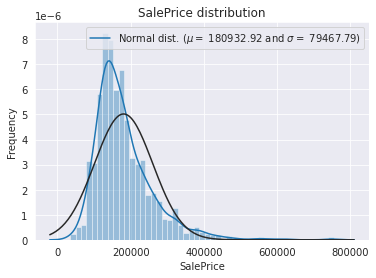

In [10]:
sns.distplot(train['SalePrice'], fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(train['SalePrice'])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu, sigma)], loc='best')
plt.ylabel("Frequency")
plt.title("SalePrice distribution")
plt.show()

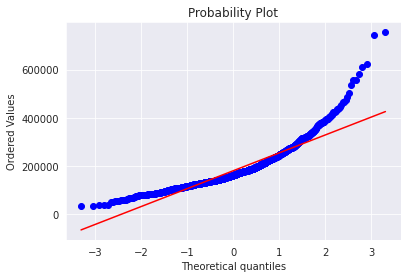

In [11]:
# QQplot
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### 2. 데이터 전처리
### 2-2. Target Variable
- SalePrice에 **`np.log1p( )`**를 이용하여 로그 변환을 취한다. 
- 마찬가지로 히스토그램과 분포 곡선을 그려보면 로그 변환 후 정규분포 곡선과 매우 유사하게 나타나는 것을 확인할 수 있다.
- QQplot도 비교적 직선에 가까워졌으므로 로그 변환 후 정규성을 만족한다고 볼 수 있다.


 mu = 12.02 and sigma = 0.40



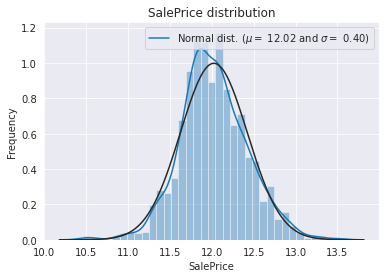

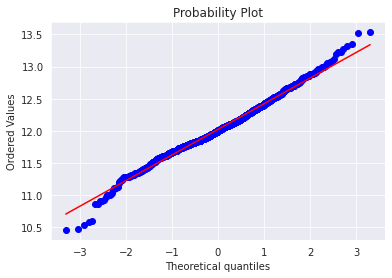

In [12]:
# 로그 변환
train['SalePrice'] = np.log1p(train['SalePrice'])

sns.distplot(train['SalePrice'], fit=norm)
(mu, sigma) = norm.fit(train['SalePrice'])
print("\n mu = {:.2f} and sigma = {:.2f}\n".format(mu, sigma))

plt.legend(["Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f})".format(mu, sigma)], loc='best')
plt.ylabel("Frequency")
plt.title("SalePrice distribution")

fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)
plt.show()

### 2. 데이터 전처리
### 2-3. Features Engineering
- **`pd.concat`**을 이용하여 train data와 test data를 행끼리 붙여 하나의 all_data로 만든다.
- 타겟 변수인 SalePrice 칼럼을 삭제하면, 데이터는 총 2917개의 자료와 79개의 칼럼을 갖는다.


In [13]:
y_train = train.SalePrice.values

all_data = pd.concat((train, test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is {}".format(all_data.shape))

all_data size is (2917, 79)


### 2. 데이터 전처리
### 2-3. Features Engineering
### 1) Missing Data
- 각 피처별로 결측치의 비율을 구한다.
- 비율이 0인 피처를 제외하고 결측치 비율이 높은 순으로 30개를 추출하여 데이터프레임으로 생성한다.
- 이 데이터프레임을 이용하여 바그래프를 그려 피처별 결측치 비율을 한눈에 시각화 할 수 있다.

In [14]:
# 결측치 비율
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
# 결측치 비율이 0인 것을 제외하고 상위 결측치 비율 30개를 내림차순으로 배열
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]

# Series 자료를 DataFrame으로 생성
missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head(20)

,Missing Ratio
PoolQC,99.691
MiscFeature,96.400
Alley,93.212
Fence,80.425
FireplaceQu,48.680
LotFrontage,16.661
GarageFinish,5.451
GarageQual,5.451
GarageCond,5.451
GarageYrBlt,5.451


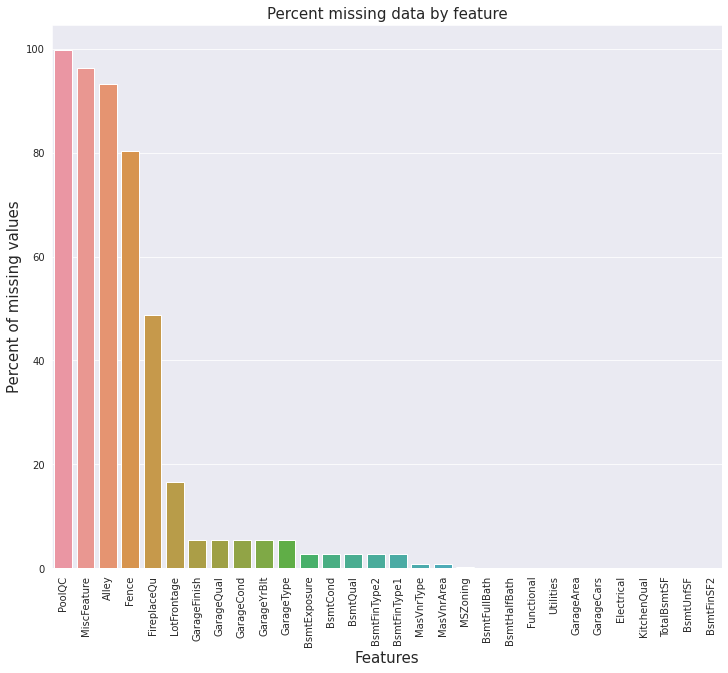

In [16]:
f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation=90)
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel("Features", fontsize=15)
plt.ylabel("Percent of missing values", fontsize=15)
plt.title("Percent missing data by feature", fontsize=15)
plt.show()

### 2. 데이터 전처리
### 2-3. Features Engineering
### 2) Data Correlation
- train data에 **`corr( )`**을 이용하여 피처간의 상관계수를 구하고, seaborn의 **`heatmap`**으로 시각화한다.
- heatmap에 vmax는 오른쪽에 위치한 컬러바의 최댓값을 지정해주는 것, square는 셀을 정사각형으로 출력하는 것이다.

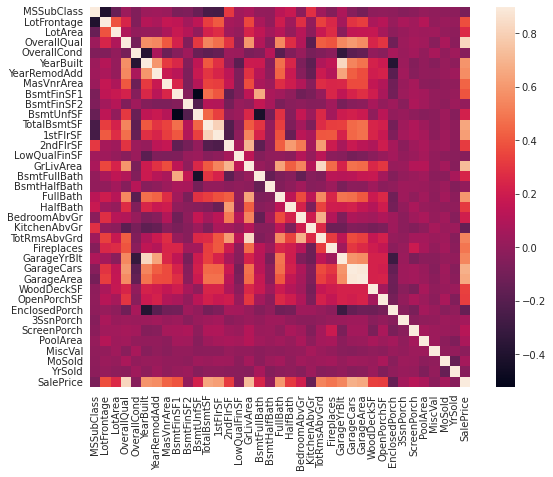

In [17]:
corrmat = train.corr()
plt.subplots(figsize=(9, 7))
sns.heatmap(corrmat, vmax=0.9, square=True)
plt.show()

### 2. 데이터 전처리
### 2-3. Features Engineering
### 3) Imputing missing values
- 결측치 비율이 높은 피처들에 대해 하나하나씩 특성을 고려하여 결측치를 처리한다.
- PoolQC : NA 값은 "No Pool"을 의미한다. 대부분의 집은 풀장이 없으므로 이상하지 않으며 풀장이 없다는 의미를 유지하여 "None"으로 대체한다.
- MiscFeature : NA 값은 "no misc feature"를 의미하며, "None"으로 대체한다.
- Alley : NA 값은 "no alley access"를 의미하며, "None"으로 대체한다.
- Fence: NA 값은 "no fence"를 의미하며, "None"으로 대체한다.
- FireplaceQu : Na 값은 "no fireplace"를 의미하며, "None"으로 대체한다.
- LotFrontage : 어떤 street에 연결된 집들은 대부분 면적이 비슷할 가능성이 높기 때문에, 결측치를 neighborhood의 그룹으로 묶어서 LotFrontage의 중앙값으로 대체한다.
- GarageType, GarageFinish, GarageQual, GarageCond : 카테고리형 변수이므로 결측치를 "None"으로 대체한다.
- GarageYrBlt, GarageArea, GarageCars : 숫자형 변수이므로 결측치를 0으로 대체한다.
- BsmtQual, BsmtCond, BsmtExposure, BsmtFinType1, BsmtFinType2 : 카테고리형 변수이므로 결측치를 "None"으로 대체한다.
- BsmtFinSF1, BsmtFinSF2, BsmtUnfSF, TotalBsmtSF, BsmtFullBath, BsmtHalfBath : 숫자형 변수이므로 결측치를 0으로 대체한다.



In [18]:
all_data['PoolQC'] = all_data['PoolQC'].fillna("None")
all_data['MiscFeature'] = all_data['MiscFeature'].fillna("None")
all_data['Alley'] = all_data['Alley'].fillna("None")
all_data['Fence'] = all_data['Fence'].fillna("None")
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna("None")

In [19]:
all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

In [21]:
for col in ('GarageType', 'GarageFinish', 'GarageQual', 'GarageCond'):
    all_data[col] = all_data[col].fillna("None")

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars'):
    all_data[col] = all_data[col].fillna(0)

for col in ('BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2'):
    all_data[col] = all_data[col].fillna("None")

for col in ('BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath'):
    all_data[col] = all_data[col].fillna(0)

### 2. 데이터 전처리
### 2-3. Features Engineering
### 3) Imputing missing values
- MasVnrType : 카테고리형 변수이므로 결측치를 "None"로 대체한다.
- MasVnrArea : 숫자형 변수이므로 결측치를 0으로 대체한다.
- Utilities : 결측치 2개, 'NoSeWa' 1개를 제외하고 나머지가 모두 "AllPub"이다. 'NoSeWa'는 훈련세트에 있어서 모델의 예측에 영향을 주지 않으므로 칼럼을 삭제한다.
- Functional : NA 값이 "typical"을 의미한다. 결측치를 "Typ"로 대체한다.
- MSZoning : 'RL'이 2263개로 가장 많으므로, 결측치를 최빈값인 'RL'로 대체한다.
- Electrical : 하나의 결측치를 갖는다. 결측치를 최빈값인 'SBrkr'로 대체한다.
- KitchenQual : 하나의 결측치를 갖는다. 결측치를 최빈값인 'TA'로 대체한다.
- Exterior1st, Exterior2nd : 하나의 결측치를 갖는다. 결측치를 각각의 최빈값으로 대체한다.
- SaleType : 결측치를 최빈값인 'WD'로 대체한다.
- MSSubClass : NA 값은 "no building class"를 의미한다. 결측치를 "None"로 대체한다. 
- 모든 피처에 대한 결측치 처리를 마치고 결측치가 남아있는지 확인하기 위해 결측치 비율을 구하는 과정을 반복한다.
- 데이터프레임의 값이 비어있는 것을 통해 남아있는 결측치가 없다는 것을 확인할 수 있다.

In [22]:
all_data['MasVnrType'] = all_data['MasVnrType'].fillna("None")
all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)

In [23]:
all_data = all_data.drop(['Utilities'], axis=1)

In [24]:
all_data['Functional'] = all_data['Functional'].fillna("Typ")
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])
all_data['Electrical'] = all_data['Electrical'].fillna(all_data['Electrical'].mode()[0])
all_data['KitchenQual'] = all_data['KitchenQual'].fillna(all_data['KitchenQual'].mode()[0])
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])
all_data['SaleType'] = all_data['SaleType'].fillna(all_data['SaleType'].mode()[0])
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [25]:
all_data_na = (all_data.isnull().sum()/len(all_data)) * 100
all_data_na = all_data_na.drop(all_data_na[all_data_na==0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({"Missing Ratio": all_data_na})
missing_data.head()

,Missing Ratio


### 2. 데이터 전처리
### 2-4. More Features Engineering
### 1) Transforming some numerical variables that are really categorical
- MSSubClass, OverallCond, YrSold, MoSold는 숫자형 변수지만 실제 피처의 값이 카테고리의 범주를 의미하는 칼럼이다.
- 이 피처들에 형변환을 적용하여 문자형으로 변환한다.

In [52]:
all_data[['MSSubClass', 'OverallCond', 'YrSold', 'MoSold']].head()

,MSSubClass,OverallCond,YrSold,MoSold
0,2.886,1.820,1.194,1.820
1,2.056,2.440,0.730,2.440
2,2.886,1.820,1.194,3.011
3,3.011,1.820,0.000,1.820
4,2.886,1.820,1.194,1.541


In [26]:
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
all_data['OverallCond'] = all_data['OverallCond'].apply(str)
all_data['YrSold'] = all_data['YrSold'].apply(str)
all_data['MoSold'] = all_data['MoSold'].apply(str)

### 2. 데이터 전처리
### 2-4. More Features Engineering
### 2) Label Encoding some categorical variables that may contain information in their ordering set
- 몇개의 카테고리형 변수에 대해 사이킷런의 **`LabelEncoder`**를 이용하여 Label Encoding을 진행한다.

In [27]:
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')

from sklearn.preprocessing import LabelEncoder
for c in cols:
    lbl = LabelEncoder()
    lbl.fit(list(all_data[c].values))
    all_data[c] = lbl.transform(list(all_data[c].values))

print("Shape all_data : {}".format(all_data.shape))

Shape all_data : (2917, 78)


### 2. 데이터 전처리
### 2-4. More Features Engineering
### 3) Adding one more important feature
- 면적과 관련된 피처들은 집의 가격을 결정하는데 매우 중요하다.
- 따라서 집의 베이스 땅의 면적과 1층, 2층의 면적을 모두 더하여 **총 면적**을 나타내는 새로운 피처를 생성한다.

In [28]:
all_data['TotalSF'] = all_data['TotalBsmtSF'] + all_data['1stFlrSF'] + all_data['2ndFlrSF']

### 4) Skewed features
- 모든 숫자형 변수에 대해 피처에 대하여 **`skew`**를 이용하여 왜곡된 정도를 구한다.
- 왜곡 정도를 내림차순으로 정렬하여 새로운 DataFrame을 생성한다.

In [29]:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = all_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("Skew in numerical features: \n")
skewness = pd.DataFrame({"skew": skewed_feats})
skewness.head(10)

Skew in numerical features: 



,skew
MiscVal,21.940
PoolArea,17.689
LotArea,13.109
LowQualFinSF,12.085
3SsnPorch,11.372
LandSlope,4.973
KitchenAbvGr,4.301
BsmtFinSF2,4.145
EnclosedPorch,4.002
ScreenPorch,3.945


### 2. 데이터 전처리
### 2-4. More Features Engineering
### 5) Box-Cox Transformation of (highly) skewed features
- **`scipy.special`**의 **`boxcox1p`**를 이용하여 the Box-Cox transformation of $1+x$를 구할 수 있다. 
- 이때 $λ=0$로 설정한다면 타겟 변수에 log1p를 사용하는 것과 동일하다.
- 앞서 구한 왜곡 정도의 절대값이 0.75 이상인 피처를 구하면 59개로, 이 피처에 대해 Box-Cox Transformation을 수행한다.
- $λ$ 값을 0.15로 설정하고, boxcox1p를 적용한다.

In [30]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform.".format(skewness.shape[0]))

There are 59 skewed numerical features to Box Cox transform.


In [31]:
from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    all_data[feat] = boxcox1p(all_data[feat], lam)

### 2. 데이터 전처리
### 2-4. More Features Engineering
### 6) Getting dummy categorical features
- 카테고리형 변수에 대해 판다스의 **`get_dummies`**를 적용하여 원핫 인코딩을 수행한다.
- 기존에 78개였던 칼럼의 개수가 220개로 증가한다.
- 전체 데이터인 all_data를 다시 train data와 test data로 분할한다.

In [32]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 220)

In [33]:
ntrain = train.shape[0]
ntest = test.shape[0]

train = all_data[:ntrain]
test = all_data[ntrain:]

### 3. 모델링
### 3-1. Import Libraries
- 모델의 훈련, 학습, 평가를 위해 필요한 라이브러리를 임포트한다.

In [34]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
import xgboost as xgb
import lightgbm as lgb

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error

### 3. 모델링
### 3-2. Define a cross validation strategy
- 사이킷런의 **`cross_val_score`**를 이용하여 교차검증을 수행하기 위한 함수를 정의한다.
- 그러나`cross_val_score`에는 셔플의 속성이 없으므로, **`KFold`**를 이용하여 교차검증에 앞서 먼저 데이터 셔플을 수행해야 한다. 
- **`get_n_splits`**를 적용하면 교차 검증기에서 분할 반복 횟수를 반환한다.

In [35]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse = np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv=kf))
    return rmse

### 3. 모델링
### 3-3. Base Models
### 1) LASSO Regression
- 라쏘 회귀는 이상치에 매우 민감하므로, 모델을 더 강력하게 만들 필요가 있다.
- **`RobustScaler`**는 특성들이 같은 스케일을 갖게 되지만 평균대신 중앙값을 사용하여 극단값에 영향을 받지 않으므로, **이상치의 영향을 최소화**할 수 있다.
- 따라서 **`make_pipeline`**을 이용하여 파이프라인에 alpha 값이 0.005인 **`Lasso`**와 **`RobustScaler`**를 함께 사용한다.

### 2) Elastic Net Regression
- 라쏘 회귀와 마찬가지로 파이프라인에 alpha 값이 0.005이고 l1_ratio가 0.9인 **`ElasticNet`**과 **`RobustScaler`**를 함께 사용한다.

### 3) Kernel Ridge Regression
- alpha값을 0.6, kernel을 'polynomial', degree는 2, coef0은 2.5로 지정한다.

In [36]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.005, random_state=1))

In [37]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.005, l1_ratio=0.9, random_state=3))

In [38]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

### 3. 모델링
### 3-3. Base Models
### 4) Gradient Boosting Regression
- 이상치에 민감한 경우에 **`GradientBoostingRegressor`**의 손실함수 loss에 'huber'를 지정한다.

### 5) XGBoost

### 6) LightGBM

In [39]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', 
                                   min_samples_leaf=15, min_samples_split=10, loss='huber', random_state=5)

In [40]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05, max_depth=3, min_child_weight=1.7817,
                             n_estimators=2200, reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213, silent=1, random_state=7, nthread=-1)

In [41]:
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, n_estimators=720, max_bin=55, bagging_function=0.8,
                              bagging_freq=5, feature_fraction=0.2319, feature_fraction_seed=9, bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

### 3. 모델링
### 3-3. Base Models
### 7) Base models scores
- 앞서 정의한 rmsle_cv 함수를 이용하여 모델을 학습시키고 예측을 진행하여 교차검증 에러를 평가한다.

In [42]:
score = rmsle_cv(lasso)
print("Lasso score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Lasso score: 0.1247 (0.0075)


In [43]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

ElasticNet score: 0.1240 (0.0076)


In [44]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Kernel Ridge score: 0.1153 (0.0075)


In [45]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Gradient Boosting score: 0.1167 (0.0083)


In [46]:
score = rmsle_cv(model_xgb)
print("XGboost score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[08:15:57] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:16:09] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:16:21] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:16:30] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[08:16:42] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

XGboost score: 0.1172 (0.0050)


In [47]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[LightGBM] [Warning] Unknown parameter: bagging_function
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] Unknown parameter: bagging_function
[LightGBM] [Warning] feature_fraction is set=0.2319, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2319
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] min_data_in_leaf is set=6, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=6
[L

### 3. 모델링
### 3-4. Stacking Models
### 1) Simplest Stacking approach : Averaging base models
- 기본 모델을 이용하여 학습, 예측하고 평균을 구하는 새로운 클래스 **AveragingModels**를 생성한다.
- **ENet, GBoost, KRR, Lasso** 4가지 모델에 대해 클래스를 적용하여 평균을 구한다.

In [48]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
    
    # Define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]

        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    # Do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [49]:
averaged_models = AveragingModels(models = (ENet, GBoost, KRR, lasso))
score = rmsle_cv(averaged_models)
print("Averaged base models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Averaged base models score: 0.1124 (0.0077)


### 3. 모델링
### 3-4. Stacking Models
### 2) Less simple Stacking : Adding a Meta-model
In this approach, we add a meta-model on averaged base models and use the out-of-folds predictions of these base models to train our meta-model.
The procedure, for the training part, may be described as follows:
1. Split the total training set into two disjoint sets (here train and .holdout )
2. Train several base models on the first part (train)
3. Test these base models on the second part (holdout)
4. Use the predictions from 3) (called out-of-folds predictions) as the inputs, and the correct responses (target variable) as the outputs to train a higher level learner called meta-model.

The first three steps are done iteratively . If we take for example a 5-fold stacking , we first split the training data into 5 folds. Then we will do 5 iterations. In each iteration, we train every base model on 4 folds and predict on the remaining fold (holdout fold).

So, we will be sure, after 5 iterations , that the entire data is used to get out-of-folds predictions that we will then use as new feature to train our meta-model in the step 4.

For the prediction part , We average the predictions of all base models on the test data and used them as meta-features on which, the final prediction is done with the meta-model.

- 새로운 클래스 **StackingAveragedModels**를 생성한다.

In [50]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds

    # Fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)

        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros(X.shape[0], len(self.base_models))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
        
        # Train the cloned meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self

    # Do the predictions of all base models on the test data and use the averaged predictions as meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_        ])
        return self.meta_model_.predict(meta_features)

In [51]:
stacked_averaged_models = StackingAveragedModels(base_models=(ENet, GBoost, KRR), meta_model=lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score : {:.4f} ({:.4f})".format(score.mean(), score.std()))

ValueError: ignored

In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

### 3. 모델링
### 3-5. Ensembling StackedRegressor, XGBoost and LightGBM
- 이전에 정의한 StackedRegressor에 XGBoost와 LightGBM을 추가한다.
- RMSE를 평가하는 함수 rmsle를 정의하여 모델 평가에 이용한다.


In [ ]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

### 3. 모델링
### 3-5. Ensembling StackedRegressor, XGBoost and LightGBM
- 먼저 3개의 모델에 대해 각각 train data로 학습 및 예측을 진행한다. train_pred로 저장하고 앞서 정의한 rmsle를 이용해서 평가하여 RMSE를 구한다.
- 3개의 모델에 각각 가중치를 곱하여 최종 train data 앙상블 예측값을 구한다. StackedRegressor은 0.70, XGBoost는 0.15, LightGBM은 0.15이다.
---
- 마찬가지로 test data를 이용하여 예측한 값을 pred로 저장하고, 각 모델에 가중치를 곱하여 최종 test data 앙상블 예측값을 구한다.

In [ ]:
# StackedRegressor
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR), meta_model = lasso)
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
print(rmsle(y_train, stacked_train_pred))

stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))

In [ ]:
# XGBoost
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
print(rmsle(y_train, xgb_train_pred))

xgb_pred = np.expm1(model_xgb.predict(test))

In [ ]:
# LightGBM
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
print(rmsle(y_train, lgb_train_pred))

lgb_pred = np.expm1(model_lgb.predict(test.values))

In [ ]:
print("RMSLE score on train data:")
print(rmsle(y_train, stacked_train_pred*0.70 + xgb_train_pred*0.15 + lgb_train_pred*0.15))

In [ ]:
# test data를 이용한 최종 앙상블 예측
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

### 4. 최종 결과 제출

In [ ]:

submission = pd.read_csv("/content/drive/MyDrive/ESAA/data/sample_submission.csv")
submission.head(5)

In [ ]:
submission['SalePrice'] = ensemble
submission.head()